<a href="https://colab.research.google.com/github/rubygitflow/Glossary-extraction/blob/main/University_of_Artificial_Intelligence_Glossary_extraction_Graduate_work_2020_v_0_6_11_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The research project — Glossary extraction

In [4]:
!nvidia-smi

Sun Nov 29 23:54:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Connecting libraries

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, concatenate, Activation, MaxPooling1D, Conv1D, BatchNormalization, Conv2DTranspose, Lambda, LSTM, GRU, Bidirectional # Импортируем стандартные слои keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from tensorflow.keras.metrics import AUC

from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import collections
%matplotlib inline
import numpy as np # Импортируем библиотеку numpy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report # статистика точности предсказания по классам
import random
import datetime
import time

import xml.etree.ElementTree as ET
import re

import os # Импортируем библиотеку os для работы с фаловой системой
from google.colab import files # Импортируем Модуль files для работы с файлами
from google.colab import drive # Подключаем гугл-диск

In [ ]:
drive.mount('/content/drive')

# Segmentation of text

## Reading and verifying data (XML parsing). 

Ссылки на файлы данных:

База_словарей_train_6.docx : https://drive.google.com/file/d/13QKXApDf8q8R_BYviX1J80BCJXUOlZUw/view?usp=sharing

База_словарей_test_6.docx : https://drive.google.com/file/d/19a1rOu6NuAb-Y_HrHhN7Ssg_ZvxTXHhH/view?usp=sharing

База_словарей_train_6.xml : https://drive.google.com/file/d/16lNQFww1QyYRxr8S4OsA2THypqxLQOra/view?usp=sharing

База_словарей_test_6.xml : https://drive.google.com/file/d/1-9fG7sdiZnjkarvitPYgX9PFt95eErPi/view?usp=sharing


In [7]:
color_meaning = {'00ffff':'термин', 'ffff00':'связка', '00ff00':'определение', 'd3d3d3':'расшифровка', 
                 'ff00ff':'дубль-термин', 'ff0000':'дубль-связка', '808000':'дубль-определение', '0000ff':'дубль-расшифровка',
                 'cyan':'термин','yellow':'связка','green':'определение', 'lightgray':'расшифровка',	                 
                 'magenta':'дубль-термин', 'red':'дубль-связка','darkyellow':'дубль-определение', 'blue':'дубль-расшифровка'}

                 #создаем словарь соответствий цвет-значение   

In [8]:
color_dic = {'термин':0,'связка':1,'определение':2,'расшифровка':3,
			       'дубль-термин':4,'дубль-связка':5,'дубль-определение':6,'дубль-расшифровка':7}

zero_symbol = 'o'

colors_count = len(color_dic) + 1 # количество уникальных тегов (не забываем про тег отсутствия класса для разметки)

skip_amount = colors_count  # кол-во пропускаемых строк под легенду при считывании данных (здесь учитывается, что есть пусая строка, в списке тегов последнее значение используется под отсутствующий класс для разметки)

In [9]:
''' 
  Словарь для цветовой разметки разобранного текста
'''
class color:
  GREY    = '\33[90m'
  RED2    = '\33[91m'
  GREEN2  = '\33[92m'
  YELLOW2 = '\33[93m'
  BLUE2   = '\33[94m'
  VIOLET2 = '\33[95m'
  LI_CYAN = '\33[96m'
  WHITE2  = '\33[97m'

  BLACK  = '\33[30m'
  RED    = '\33[31m'
  GREEN  = '\33[32m'
  YELLOW = '\33[33m'
  BLUE   = '\33[34m'
  VIOLET = '\33[35m'
  CYAN   = '\33[36m'
  WHITE  = '\33[37m'

  GREYBG    = '\33[100m'
  REDBG2    = '\33[101m'
  GREENBG2  = '\33[102m'
  YELLOWBG2 = '\33[103m'
  BLUEBG2   = '\33[104m'
  VIOLETBG2 = '\33[105m'
  LI_CYANBG = '\33[106m'
  WHITEBG2  = '\33[107m'

  BLACKBG  = '\33[40m'
  REDBG    = '\33[41m'
  GREENBG  = '\33[42m'
  YELLOWBG = '\33[43m'
  BLUEBG   = '\33[44m'
  VIOLETBG = '\33[45m'
  CYANBG   = '\33[46m'
  WHITEBG  = '\33[47m'


  BOLD 		  = '\33[1m'
  ITALIC 	  = '\33[3m'
  UNDERLINE = '\33[4m'

  BLINK    = '\33[5m'
  BLINK2   = '\33[6m'
  SELECTED = '\33[7m'
  END 		 = '\33[0m'
  
dic_color = {0:color.LI_CYANBG+color.BLACK, 1:color.YELLOWBG2+color.BLACK, 2:color.GREENBG2+color.BLACK, 3:color.WHITEBG+color.BLACK,
			       4:color.VIOLETBG2+color.WHITE2, 5:color.REDBG2+color.WHITE2, 6:color.YELLOWBG+color.BLACK, 7:color.BLUEBG+color.WHITE2}

In [ ]:
colors_count

In [11]:
# названия необходимых тегов для извлекаемых категорий
r = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}r'
rpr = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}rPr'
t = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}t'
shd = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}shd'
fill = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}fill'
highlight = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}highlight'
val = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}val'

### **Function library**

In [12]:
'''
  Сервиная функция:
  Загрузка выборки заданного количества фраз из файла 
'''
def load_xml(filename, paragraphs_amount):
    test_tree = ET.parse(filename)

    test_root = test_tree.getroot()
    test_body = test_root[0]
    test_row_count = paragraphs_amount + skip_amount
    return list(iter(test_body))[:test_row_count]

In [13]:
'''
  Сервиная функция:
  Вставка пробела в заданной позиции в строке
'''
def insert_space(text, index):
  return text[:index] + ' ' + text[index:]

In [14]:
'''
  Основная функция для подготовки обучающей выборки.
  Создаём параллельные массивы с текстом и категориями лексем.
'''
def pars_xml(ps):
    # Массивы данных по параграфам
    paragraphs = []
    tags = []
    exception_amount = 0
    exception_array = []
    # Массив фактических цветов в файле исходных данных
    colors = set() # все цвета в документе
    # длина массива лексем в параграфе
    max_paragraph_len = 0  # Максимальная длина предложения
    max_paragraph_len_ind = -1  # Индекс предложения с максимальной длиной

    for i, paragraph in enumerate(ps): # проходим по всем абзацам
        if i > colors_count - 1:     # пропускаем легенду для цветовой разметки    
            phrases_list = paragraph.findall(r) # находим все фразы (часть новости)
            p_words = [] # список сущностей в абзаце
            tags_w = [] # список семантических цветов для слов в абзаце

            last_ind = len(phrases_list)-1
            for ind, phrase in enumerate(phrases_list): # проходим по всем фразам в абзаце
                words = [] # список сущностей во фразе
                y_list = [] # категории для сущностей во фразе

                try:
                  text = phrase.find(t).text # получаем текст, содержащийся во фразе

                  # if i>1300:
                  #   print(i,last_ind, text)

                  # 1) выделяем пробелом точку (воскл.зн., вопр.зн., двоеточние) в конце предложения
                  text_comma = text.strip()
                  len_text = len(text_comma)-1
                  if ind==last_ind and len_text>0: 
                    if text_comma[len_text] in ['.', ':', '!', '?']:
                      text_comma = insert_space(text_comma, len_text)
                    
                  # 2) выделяем пробелами символы: , { } ( ) [ ] ; « » „ “ "
                  text_comma = text_comma.replace(',', ' , ')
                  text_comma = text_comma.replace('(', ' ( ')
                  text_comma = text_comma.replace(')', ' ) ')
                  text_comma = text_comma.replace('[', ' [ ')
                  text_comma = text_comma.replace(']', ' ] ')
                  text_comma = text_comma.replace('{', ' { ')
                  text_comma = text_comma.replace('}', ' } ')
                  text_comma = text_comma.replace('"', ' " ')
                  text_comma = text_comma.replace('„', ' „ ')
                  text_comma = text_comma.replace('“', ' “ ')
                  text_comma = text_comma.replace('«', ' « ')
                  text_comma = text_comma.replace('»', ' » ')
                  text_comma = text_comma.replace(';', ' ; ')


                  # 3) заменяем все виды пробелов одиночным пробелом #32  
                  text_comma = text_comma.replace('\xa0', '')
                  text_comma = text_comma.replace('\x301', '')
                  text_comma = text_comma.replace('\u0301', '')
                  text_comma = text_comma.replace('\ufeff', '')
                  text_comma = text_comma.replace('  ', ' ')
                  text_comma = text_comma.replace('  ', ' ')
                  text_comma = text_comma.strip()      

                  # 4) выделяем левым пробелом двоеточие (:) при одновременном выполнении условий: 
                  # после двух буквенных символов в любом алфавите и перед правым пробелом. 
                  # https://habr.com/ru/post/349860/
                  text_comma = re.sub(r'(\w\w)(:)(\s)',  r'\1 \2\3', text_comma)


                  if (len(text_comma)>0):
                    text_comma = text_comma.lower()

                    style = phrase.find(rpr) # получаем стили фразы
                    
                    if style.find(shd) is not None: # если размечали через заливку
                        color = style.find(shd).attrib[fill] # получаем значение цвета заливки
                    elif style.find(highlight) is not None: # если размечали через хайлайт
                        color = style.find(highlight).attrib[val] # получаем значение цвета хайлайта
                    else:
                        color = 'white' # иных вариантов выделения в word нет, значит эта фраза не выделена (белый цвет)
                    color = color.lower() # переводим строковое значение цвета в нижний регистр
                    meaning = color_meaning[color] if color in color_meaning else '' # если есть цвет в словаре цвет-значение, то получаем значение. в противном случае у фразы значение не было выделено
                    
                    colors.add(color) # добавляем цвет в словарь всех встреченных цветов, если нужно проанализировать их
                    
                    words = text_comma.split()
                    k = len(words)
                    if meaning in color_dic: # если во фразе присутствует какая-то выделяемая сущность
                      for j in range(k):
                        y_list.append(meaning) # получаем индекс позиции, соответствующей какой-то семантической(смысловой) окраске и устанавливаем по этому индексу абсолютное значение категории
                    else:
                      for j in range(k):
                        y_list.append(zero_symbol)

                    p_words += words  # список сущностей в параграфе
                    tags_w += y_list # список семантических цветов для слов в параграфе

                except Exception:
                  exception_amount += 1
                  exception_array.append(i)

            # print(i, p_words)
            if p_words:
              paragraphs.append(p_words)
              tags.append(tags_w)
              
            if len(p_words) >= max_paragraph_len: 
              max_paragraph_len = len(p_words)
              max_paragraph_len_ind = i - skip_amount

        if i%100==0:
            print('line',i)

    return     paragraphs, tags, colors, max_paragraph_len, max_paragraph_len_ind, exception_array

In [15]:
'''
  Графическая функция:
  Подсчёт и вывод на печать статистики о содержании категорий определительных структур в размеченных текстах
'''
def class_stat(paragraphs, tags, ext_print = False):
  classes = np.zeros((colors_count))
  len_tags = len(tags)
  print('Длина размеченной выборки:', len_tags)
  if ext_print:
    print("\nПеречень фраз со 100% разметкой:")
  for i, elem in enumerate(tags):
    if zero_symbol in elem:
      if len(set(elem))==1:
        classes[0] += 1
    else:
      if ext_print:
        print("paragraphs[{}]".format(i), '=',paragraphs[i])
        print("tags[{}]".format(i), '=',tags[i])
        print(" ")
    for item in list(color_dic.keys()):
      if item in elem:
        real_index = int(color_dic[item]) + 1
        classes[real_index] += 1
  print("\nСтатистика по классам")
  for i in range(len(classes)):
    if i==0:
      print(f'Фраз без определительных структур: {classes[0]} - {round(classes[0]*100./len_tags,2)}%')
    else:
      key=list(color_dic.keys())[list(color_dic.values()).index(i-1)] # ключ по значению
      print(f'Фраз с категорией {key}: {classes[i]} - {round(classes[i]*100./len_tags,2)}%')

In [16]:
'''
  Графическая функция:
  Построение статистических графиков по входным данным.
'''
def draw_paragraphs_stat(paragraphs):
  # https://pyprog.pro/mpl/mpl_bar.html
  counter = []
  for elem in paragraphs:
    counter.append(len(elem))

  plt.figure(figsize=(27, 5))
  plt.grid(True)
  plt.bar(range(len(paragraphs)), counter)
  plt.suptitle('Фактическое распределение длин абзацев (в лексемах)')
  plt.show()

  dic_counter = collections.Counter(counter)
  print('Collections',dic_counter)

  plt.figure(figsize=(15, 5))
  plt.grid(True)
  plt.bar(dic_counter.keys(), dic_counter.values())
  plt.suptitle('Статистика кол-ва абзацев по их длинам')
  plt.show()

  return counter, dic_counter

### Training sample

In [17]:
paragraphs_amount = 1809
ps_train = load_xml('/content/drive/My Drive/Базы/NLP/База_словарей_train_6.xml', paragraphs_amount)

In [ ]:
paragraphs_train, tags_train, train_colors, max_paragraph_len, max_paragraph_len_ind, exception_array  = pars_xml(ps_train)
paragraphs_amount = len(paragraphs_train)  # обновляем длину массива на случай наличия в исходной базе пустых строк
paragraphs_amount, exception_array # контрольный вывод на размера принятых данных и массива индексов пустых строк

In [ ]:
if len(train_colors) > colors_count:
  print('В документе цветов разметки больше допустимого')
train_colors # выведем все цвета, которые мы встретили

In [ ]:
print(len(paragraphs_train))
print(len(tags_train))

print('Максимальная длина предложения — max_paragraph_len =',max_paragraph_len)
print('Индекс предложения с максимальной длиной — max_paragraph_len_ind =',max_paragraph_len_ind)

In [22]:
# Корректируем максимальную длину предложения для использования U-net сеток
max_paragraph_len = 128

In [ ]:
train_paragraphs_len = len(paragraphs_train)
print('Длина обучающей выборки:', train_paragraphs_len)

**Извлекаем статистику по абзацам**

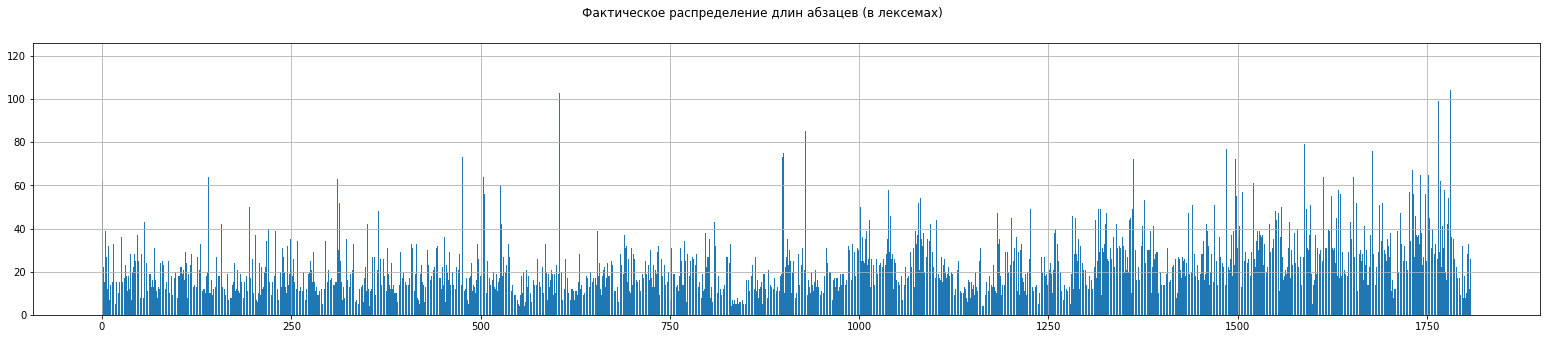

Collections Counter({14: 92, 13: 85, 19: 85, 12: 77, 15: 74, 16: 74, 11: 73, 18: 70, 20: 60, 22: 59, 10: 56, 17: 55, 23: 51, 25: 50, 26: 49, 21: 48, 9: 47, 8: 45, 27: 41, 24: 41, 29: 38, 30: 37, 31: 37, 7: 36, 28: 35, 33: 27, 32: 26, 6: 26, 5: 25, 35: 21, 37: 19, 36: 18, 39: 16, 38: 16, 34: 15, 42: 14, 40: 14, 41: 13, 45: 13, 4: 10, 43: 8, 51: 8, 44: 8, 47: 7, 49: 7, 62: 6, 50: 6, 52: 6, 56: 6, 48: 5, 46: 5, 64: 4, 53: 4, 58: 4, 57: 4, 73: 3, 55: 3, 61: 2, 54: 2, 72: 2, 59: 2, 65: 2, 3: 1, 63: 1, 60: 1, 103: 1, 75: 1, 85: 1, 69: 1, 83: 1, 77: 1, 79: 1, 120: 1, 76: 1, 67: 1, 80: 1, 99: 1, 88: 1, 104: 1})


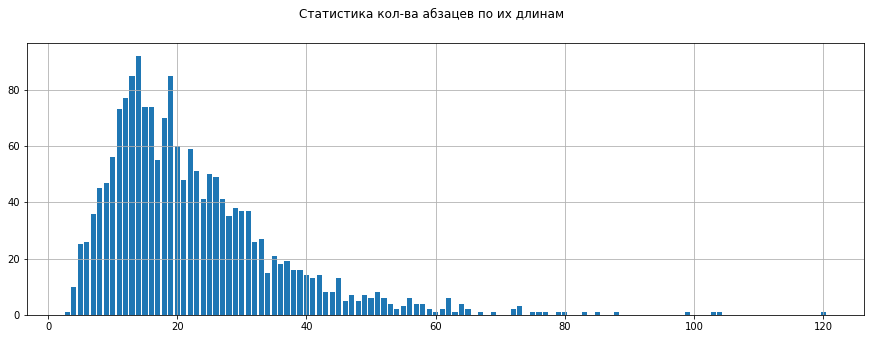

In [24]:
train_counter, train_count = draw_paragraphs_stat(paragraphs_train)

**Во скольких фразах встречается тот или  иной класс**

In [25]:
class_stat(paragraphs_train, tags_train)

Длина размеченной выборки: 1809

Статистика по классам
Фраз без определительных структур: 316.0 - 17.47%
Фраз с категорией термин: 1479.0 - 81.76%
Фраз с категорией связка: 1455.0 - 80.43%
Фраз с категорией определение: 1462.0 - 80.82%
Фраз с категорией расшифровка: 711.0 - 39.3%
Фраз с категорией дубль-термин: 352.0 - 19.46%
Фраз с категорией дубль-связка: 257.0 - 14.21%
Фраз с категорией дубль-определение: 238.0 - 13.16%
Фраз с категорией дубль-расшифровка: 56.0 - 3.1%


### Testing sample

In [ ]:
test_paragraphs_amount = 452
ps_test = load_xml('/content/drive/My Drive/Базы/NLP/База_словарей_test_6.xml', test_paragraphs_amount)
print(len(ps_test))

In [ ]:
paragraphs_test, tags_test, test_colors, max_test_paragraph_len, max_test_paragraph_len_ind, test_exception_array  = pars_xml(ps_test)
test_paragraphs_amount = len(paragraphs_test)  # обновляем длину массива на случай наличия в исходной базе пустых строк
test_paragraphs_amount, test_exception_array # контрольный вывод на размера принятых данных и массива индексов пустых строк

In [ ]:
if len(test_colors) > colors_count:
  print('В документе цветов разметки больше допустимого')
test_colors # выведем все цвета, которые мы встретили

In [ ]:
print(len(paragraphs_test))
print(len(tags_test))

print('Максимальная длина предложения — max_test_paragraph_len =',max_test_paragraph_len)
print('Индекс предложения с максимальной длиной — max_test_paragraph_len_ind =',max_test_paragraph_len_ind)

In [30]:
# Корректируем максимальную длину предложения для использования U-net сеток
max_test_paragraph_len = max_paragraph_len

**Извлекаем статистику по абзацам**

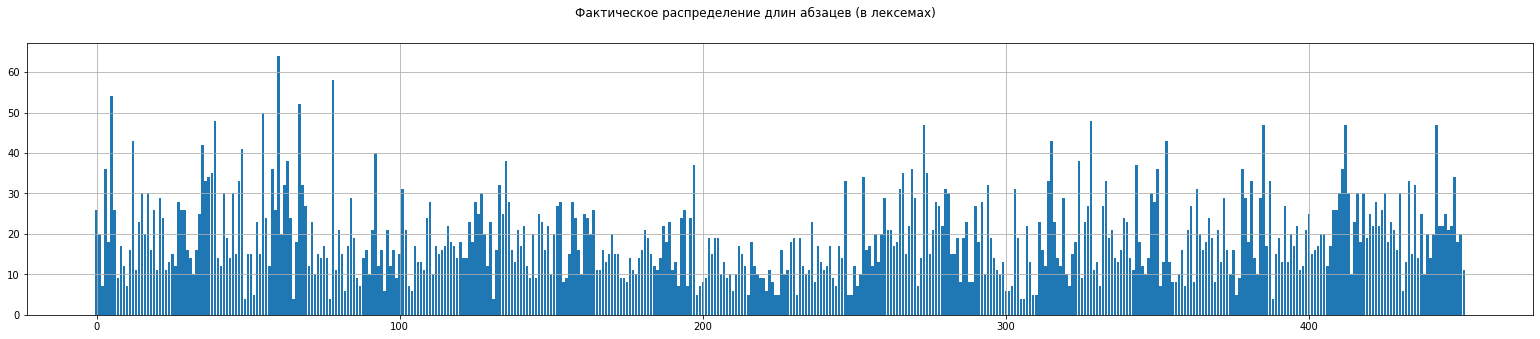

Collections Counter({16: 24, 15: 24, 10: 23, 14: 22, 12: 21, 11: 19, 13: 19, 17: 18, 20: 17, 18: 17, 19: 16, 7: 15, 9: 15, 23: 15, 21: 15, 30: 13, 22: 13, 8: 12, 26: 11, 5: 11, 24: 10, 28: 10, 25: 9, 29: 8, 33: 8, 27: 8, 6: 8, 4: 7, 36: 6, 32: 5, 31: 5, 47: 4, 43: 3, 34: 3, 35: 3, 38: 3, 48: 2, 37: 2, 54: 1, 42: 1, 41: 1, 50: 1, 64: 1, 52: 1, 58: 1, 40: 1})


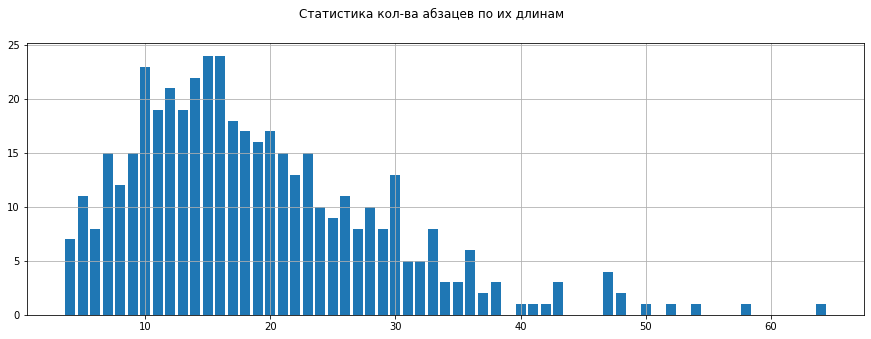

In [31]:
test_counter, test_count = draw_paragraphs_stat(paragraphs_test)

**Во скольких фразах встречается тот или  иной класс**

In [32]:
class_stat(paragraphs_test, tags_test)

Длина размеченной выборки: 452

Статистика по классам
Фраз без определительных структур: 64.0 - 14.16%
Фраз с категорией термин: 388.0 - 85.84%
Фраз с категорией связка: 384.0 - 84.96%
Фраз с категорией определение: 387.0 - 85.62%
Фраз с категорией расшифровка: 199.0 - 44.03%
Фраз с категорией дубль-термин: 91.0 - 20.13%
Фраз с категорией дубль-связка: 46.0 - 10.18%
Фраз с категорией дубль-определение: 52.0 - 11.5%
Фраз с категорией дубль-расшифровка: 7.0 - 1.55%


## Preparing a dataset

Объединим обучающий и тестовый массивы, чтобы воспользоваться общим токенизатором.

In [ ]:
all_paragraphs = paragraphs_train + paragraphs_test
all_tags = tags_train + tags_test
print(len(all_paragraphs))
print(len(all_tags))

In [34]:
all_paragraphs_together = [' '.join(sequence) for sequence in all_paragraphs]

In [ ]:
all_paragraphs_together[max_paragraph_len_ind]

In [36]:
all_tags_together = [' '.join(tag) for tag in all_tags]

In [ ]:
all_tags_together[max_paragraph_len_ind]

In [38]:
num_words = 11600
sent_len = max_paragraph_len 
tokenizer = Tokenizer(num_words, filters=' \t\n', oov_token='<UNK>')

In [39]:
tokenizer.fit_on_texts(all_paragraphs_together)

In [ ]:
# реальная длина словаря. Сравниваем со значением num_words
len(tokenizer.index_word)

In [41]:
tag_tokenizer = Tokenizer(filters=' ') # colors_count - количество категорий - лучше не указывать, чтобы не потерять категории. Все они автоматически подцедпляются под своими индексами

In [42]:
tag_tokenizer.fit_on_texts(all_tags_together)

In [ ]:
tag_tokenizer.index_word # Здесь обращаем внимание, что фактическая нумерация индексов смещена на единицу по сравнению с массивом color_dic

In [ ]:
tag_tokenizer.word_index

In [ ]:
len(tag_tokenizer.index_word) # эта величина равна colors_count

In [ ]:
# prepare color dictionary
tag_tokenizer_dic_color = {}
tag_tokenizer_dic_color[1] = color.END
for i in range(2,10):
  tag_tokenizer_dic_color[i] = dic_color[color_dic[tag_tokenizer.index_word[i]]]
tag_tokenizer_dic_color

In [47]:
'''
  Сервисная функция:
  Сделать разметку текста цветом
'''
def tokens_to_text(x_arr, y_arr, max_len = 0):
  res = '' 
  str_len = 0
  def add_col(col, txt):
    nonlocal res, str_len
    if max_len > 0:
      next_len = len(txt)
      if str_len + next_len > max_len:
        res = res + col + '\n ' + txt
        str_len = next_len + 1
      else:
        res = res + col + ' ' + txt
        str_len += next_len + 1
    else:
      res = res + col + ' ' + txt

  for i, el in enumerate(x_arr):
    if el==0:
      break
    col_ind = y_arr[i].argmax() + 1
    add_col(tag_tokenizer_dic_color[col_ind], tokenizer.index_word[el])

  return res + color.END

**Проверка входящих и исходящих массивов на соответствие их размерностей** 

(для выявления факта порчи данных функцией Tokenizer)

In [48]:
X = tokenizer.texts_to_sequences(all_paragraphs_together)

In [49]:
Y = tag_tokenizer.texts_to_sequences(all_tags_together)

In [ ]:
len(X)==len(Y)

In [51]:
# Проверка на согласованность входных и выходных данных
for i, elem in enumerate(X):
  if len(Y[i]) != len(X[i]):
    print('X[{}] ='.format(i),X[i])
    print('Y[{}] ='.format(i),Y[i])
    # Если все массивы равны, то здесь  ничего не должно печататься
  else:
    pass
    # print('len(X[{}]) ='.format(i),len(Y[i]))

**Выравнивание массивов до максимального размера абзаца**

In [52]:
X = pad_sequences(X, sent_len, padding='post', truncating='post') # заполнение в конце и обрезка с конца предложения

In [ ]:
X.shape

In [54]:
Y = pad_sequences(Y, sent_len, value=1, padding='post', truncating='post') # заполнение в конце и обрезка с конца предложения

In [ ]:
Y.shape

In [56]:
Y = to_categorical(Y, colors_count+1)  # см. лекцию "Занятие № 6 Углубленный курс по текстам" https://youtu.be/Nfw7ZY-WzS8?t=1533

In [ ]:
Y.shape

In [ ]:
Y = Y[:, :, 1:]  # см. лекцию "Занятие № 6 Углубленный курс по текстам" https://youtu.be/Nfw7ZY-WzS8?t=1533
Y.shape

In [ ]:
print(tokens_to_text(X[13], Y[13], 130))

In [60]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=train_paragraphs_len, shuffle=False) # Не перемешиваем данные и берём целую часть на тренировочную выборку

### Total for training and testing samples we have:

In [61]:
print('Xtrain.shape=',Xtrain.shape)
print('Xtest.shape=',Xtest.shape)
print('Ytrain.shape=',Ytrain.shape)
print('Ytest.shape=',Ytest.shape)

Xtrain.shape= (1809, 128)
Xtest.shape= (452, 128)
Ytrain.shape= (1809, 128, 9)
Ytest.shape= (452, 128, 9)


In [62]:
# Пример окраски размеченного текста
print(tokens_to_text(Xtest[30], Ytest[30], 130))

 закон дисперсии — в физике закон , выражающий зависимость фазовой скорости волны от её частоты .


## Models

In [64]:
emb_size = 128

In [65]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

In [66]:
model_dir = "/content/drive/My Drive/tmp/"

In [67]:
'''
  callback-функция сохранения на диск лучшей модели в процессе обучения
  запись осуществляется на google-диск
'''
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="val_dice_coef",
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        verbose=1
    )
]

### **Linear segmentation neural network**

### **Recurrent neural network GRU**

#### Algorithm: Embedding + Bidirectional(GRU) + GRU , batch_size = 128, activation='softmax'

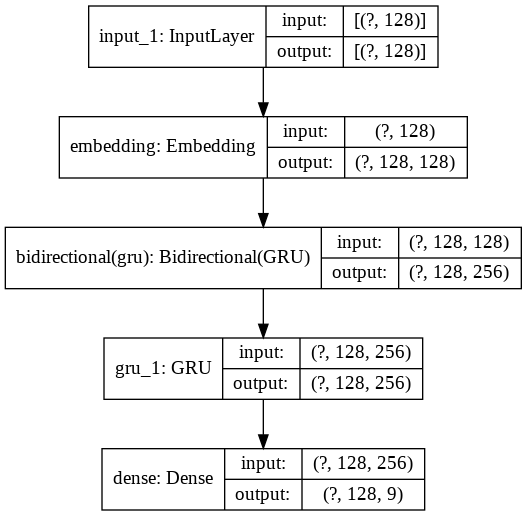

In [68]:
input = Input((sent_len,))
# input = Input(shape=(None,))
x = Embedding(num_words, emb_size)(input)
x = Bidirectional(GRU(emb_size, return_sequences=True))(x)
x = GRU(emb_size * 2, return_sequences=True)(x)
output = Dense(colors_count, activation='softmax')(x)

modelEGRU = Model(input, output)

modelEGRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[dice_coef])
# modelEGRU.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=[dice_coef, AUC(num_thresholds=150)])

plot_model(modelEGRU, show_shapes=True)

In [69]:
historyEGRU = modelEGRU.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(Xtest, Ytest),  
                    callbacks=callbacks_list,
                    verbose=1)
                    
modelEGRU.save( '/content/drive/My Drive/tmp/modelEGRU_100epochs(gl_extr).h5' )

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.9061 - dice_coef: 0.6251
Epoch 00001: val_dice_coef improved from -inf to 0.88533, saving model to /content/drive/My Drive/tmp/weights_epoch_1
15/15 [==============================] - 2s 151ms/step - loss: 0.9061 - dice_coef: 0.6251 - val_loss: 0.2767 - val_dice_coef: 0.8853
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.3222 - dice_coef: 0.8600
Epoch 00002: val_dice_coef improved from 0.88533 to 0.88543, saving model to /content/drive/My Drive/tmp/weights_epoch_2
15/15 [==============================] - 1s 50ms/step - loss: 0.3222 - dice_coef: 0.8600 - val_loss: 0.2589 - val_dice_coef: 0.8854
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.2824 - dice_coef: 0.8788
Epoch 00003: val_dice_coef improved from 0.88543 to 0.89206, saving model to /content/drive/My Drive/tmp/weights_epoch_3
15/15 [==============================] - 1s 97ms/step - loss: 0.2824 - dice_coef: 0.878

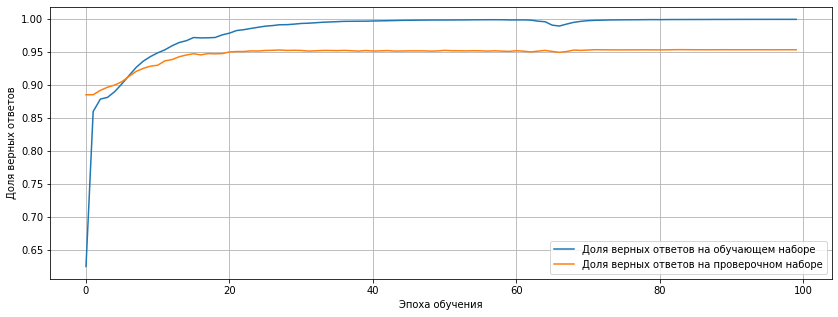

In [70]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyEGRU.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyEGRU.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


**Проверка тренировочной выборки (насколько хорошо выучены примеры)**

In [72]:
YpredEGRU_train = modelEGRU.predict(Xtrain)

In [ ]:
for i, el in enumerate(Xtrain):
  print(f'{i+1}.')
  print(tokens_to_text(el, Ytrain[i]))
  print(tokens_to_text(el, YpredEGRU_train[i]))

*Чтобы память не забивать, результат 100%-го совпадения предсказаний с разметкой обучающей выборки удалён из текста*

**Проверка тестовой выборки (насколько хорошо обучена сеть)**

In [74]:
YpredEGRU_test = modelEGRU.predict(Xtest)

In [ ]:
# выбираем конкретную фразу из тестовой выборки
i = 2 + 1
print(f'{i}.')
print(tokens_to_text(Xtest[i], Ytest[i]))
print(tokens_to_text(Xtest[i], YpredEGRU_test[i]))

In [ ]:
# воспроизводим все фразы из тестовой выборки
for i, el in enumerate(Xtest):
  print(f'{i+1}.')
  print(tokens_to_text(el, Ytest[i]))
  print(tokens_to_text(el, YpredEGRU_test[i]))

# На github не отображается расцветка текста
# Чтобы её посмотреть, воспользуйтесь ссылкой на https://colab.research.google.com/

1.
 удобный поиск — возможность использования эффективной системы поиска ( полнотекстовый поиск , одновременный поиск в нескольких словарях , высокая скорость поиска ) [ 26 ] .
 удобный поиск — возможность использования эффективной системы поиска ( полнотекстовый поиск , одновременный поиск в нескольких словарях , высокая скорость поиска ) [ 26 ] .
2.
 синтаксический анализатор ( жарг. парсер ← англ. parser ) — это программа или часть программы , выполняющая синтаксический анализ .
 синтаксический анализатор ( жарг. парсер ← англ. parser ) — это программа или часть программы , выполняющая синтаксический анализ .
3.
 свойство — необходимое условие принадлежности классу .
 свойство — необходимое условие принадлежности классу .
4.
 парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее пон

In [78]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredEGRU_test.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.98      0.98      0.98     52328
      расшифровка       0.66      0.70      0.68      1811
      определение       0.71      0.74      0.72      1849
           термин       0.71      0.69      0.70       746
           связка       0.77      0.85      0.81       566
     дубль-термин       0.49      0.28      0.35       249
дубль-определение       0.16      0.09      0.12       172
     дубль-связка       0.29      0.19      0.23        79
дубль-расшифровка       0.00      0.00      0.00        56

         accuracy                           0.95     57856
        macro avg       0.53      0.50      0.51     57856
     weighted avg       0.95      0.95      0.95     57856



### **One-dimensional convolution**

#### Алгоритм: Embedding + Conv1D , batch_size = 16, activation='softmax'
Оборачиваем алгоритм в функцию: **linearSegmentationNet**

In [84]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - sentence_len - длина предложения
    - num_words - количество слов в словаре
    - embedding_size - длина эмбединга
'''
def linearSegmentationNet(
      num_classes = 9,
      sentence_len = 200,
      num_words = 5000,
      activation_function = 'softmax',
      embedding_size = 500
      ):
    input = Input((sentence_len,))                                          # Создаем входной слой с размерностью input_shape
    emb = Embedding(num_words, embedding_size)(input)
    x = Conv1D(64, 3, padding='same', name='block1_conv1')(emb) # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv1D(128, 5, padding='same', name='block1_conv2')(x)         # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv1D(num_classes,3, activation=activation_function, padding='same')(x) # Добавляем Conv1D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(input, x)                                             # Создаем модель с входом 'input' и выходом 'x'

    # Компилируем модель
    # model.compile(optimizer=Adam(lr=1e-3),
    model.compile(optimizer='rmsprop', 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    return model # Возвращаем сформированную модель

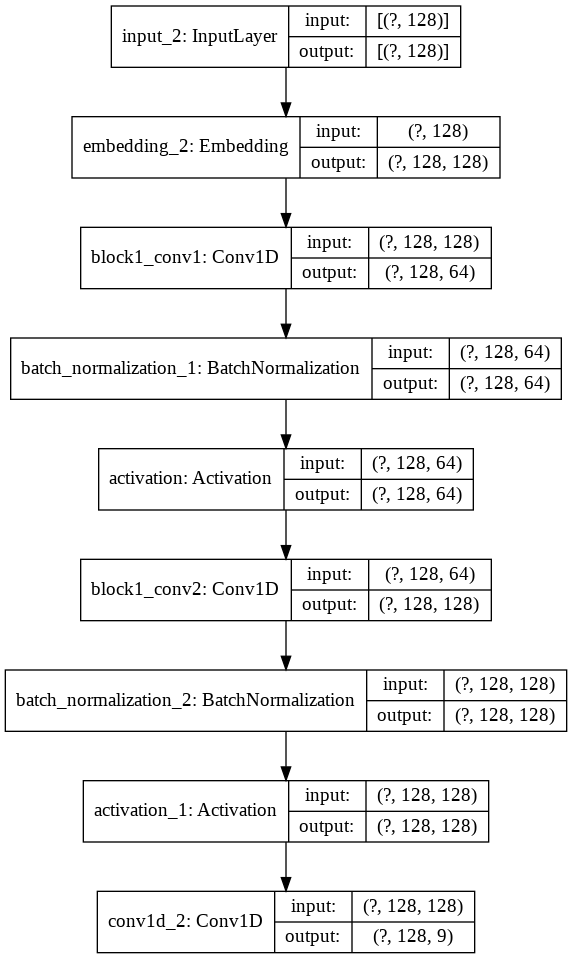

In [85]:
modelL = linearSegmentationNet(colors_count, sent_len, num_words, 'softmax', emb_size) # Создаем модель linearSegmentationNet
plot_model(modelL, show_shapes=True)

In [86]:
historyL = modelL.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=16,
                    validation_data=(Xtest, Ytest)) # Обучаем модель на выборке по всем классам

Epoch 1/100
114/114 [==============================] - 1s 10ms/step - loss: 0.3225 - dice_coef: 0.8453 - val_loss: 0.3274 - val_dice_coef: 0.8622
Epoch 2/100
114/114 [==============================] - 1s 9ms/step - loss: 0.1610 - dice_coef: 0.9257 - val_loss: 0.3233 - val_dice_coef: 0.8964
Epoch 3/100
114/114 [==============================] - 1s 9ms/step - loss: 0.1002 - dice_coef: 0.9518 - val_loss: 0.2489 - val_dice_coef: 0.8870
Epoch 4/100
114/114 [==============================] - 1s 9ms/step - loss: 0.0561 - dice_coef: 0.9711 - val_loss: 0.2401 - val_dice_coef: 0.8994
Epoch 5/100
114/114 [==============================] - 1s 9ms/step - loss: 0.0317 - dice_coef: 0.9824 - val_loss: 0.2197 - val_dice_coef: 0.9247
Epoch 6/100
114/114 [==============================] - 1s 8ms/step - loss: 0.0185 - dice_coef: 0.9888 - val_loss: 0.2771 - val_dice_coef: 0.9331
Epoch 7/100
114/114 [==============================] - 1s 8ms/step - loss: 0.0126 - dice_coef: 0.9924 - val_loss: 0.2778 - val_di

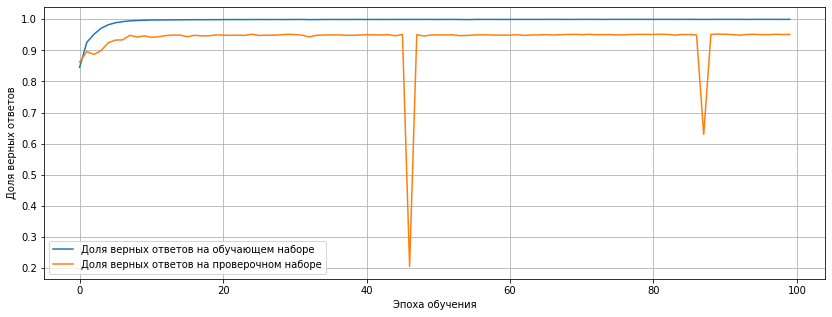

In [87]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyL.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyL.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [88]:
YpredL = modelL.predict(Xtest)

In [89]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredL.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.98      0.98      0.98     52328
      расшифровка       0.60      0.56      0.58      1811
      определение       0.63      0.71      0.67      1849
           термин       0.76      0.73      0.74       746
           связка       0.81      0.84      0.83       566
     дубль-термин       0.57      0.33      0.42       249
дубль-определение       0.28      0.21      0.24       172
     дубль-связка       0.36      0.18      0.24        79
дубль-расшифровка       0.00      0.00      0.00        56

         accuracy                           0.95     57856
        macro avg       0.56      0.51      0.52     57856
     weighted avg       0.95      0.95      0.95     57856



### **U-net**




In [90]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - sentence_len - длина предложения
    - num_words - количество слов в словаре
    - embedding_size - длина эмбединга
'''

def unet(
      num_classes = 6,
      sentence_len = 200,
      num_words = 5000,
      activation_function = 'softmax',
      embedding_size = 50
      ):
    print('num_classes=',num_classes)
    print('sentence_len=',sentence_len)
    print('num_words=',num_words)
    print('embedding_size=',embedding_size)

    txt_input = Input((sentence_len,))                                         # Создаем входной слой с размерностью input_shape
    print('txt_input=',txt_input.shape)
    emb = Embedding(num_words, embedding_size)(txt_input)
    print('emb=',emb.shape)

    # Block 1
    x = Conv1D(64, 3, padding='same', name='block1_conv1')(emb) # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same', name='block1_conv2')(x)         # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling1D()(block_1_out)                                        # Добавляем слой MaxPooling1D

    # Block 2
    x = Conv1D(128, 3, padding='same', name='block2_conv1')(x)        # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(128, 3, padding='same', name='block2_conv2')(x)        # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling1D()(block_2_out)                                        # Добавляем слой MaxPooling1D

    # Block 3
    x = Conv1D(256, 3, padding='same', name='block3_conv1')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same', name='block3_conv2')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same', name='block3_conv3')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling1D()(block_3_out)                                        # Добавляем слой MaxPooling1D

    # Block 4
    x = Conv1D(512, 3, padding='same', name='block4_conv1')(x)        # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block4_conv2')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block4_conv3')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    # x = Conv1DTranspose(x, 256, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 256 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(256, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv1D(256, 3, padding='same')(x)                             # Добавляем слой Conv1D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    # x = Conv1DTranspose(x, 128, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 128 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(128, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv1D(128, 3, padding='same')(x)                             # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(128, 3, padding='same')(x) # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # UP 4
    # x = Conv1DTranspose(x, 64, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 64 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(64, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
    x = Conv1D(64, 3, padding='same')(x) # Добавляем слой Conv1D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same')(x) # Добавляем слой Conv1D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv1D(num_classes, 3, activation='softmax', padding='same')(x)  # Добавляем Conv1D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(txt_input, x) # Создаем модель с входом 'txt_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

num_classes= 9
sentence_len= 128
num_words= 11600
embedding_size= 128
txt_input= (None, 128)
emb= (None, 128, 128)


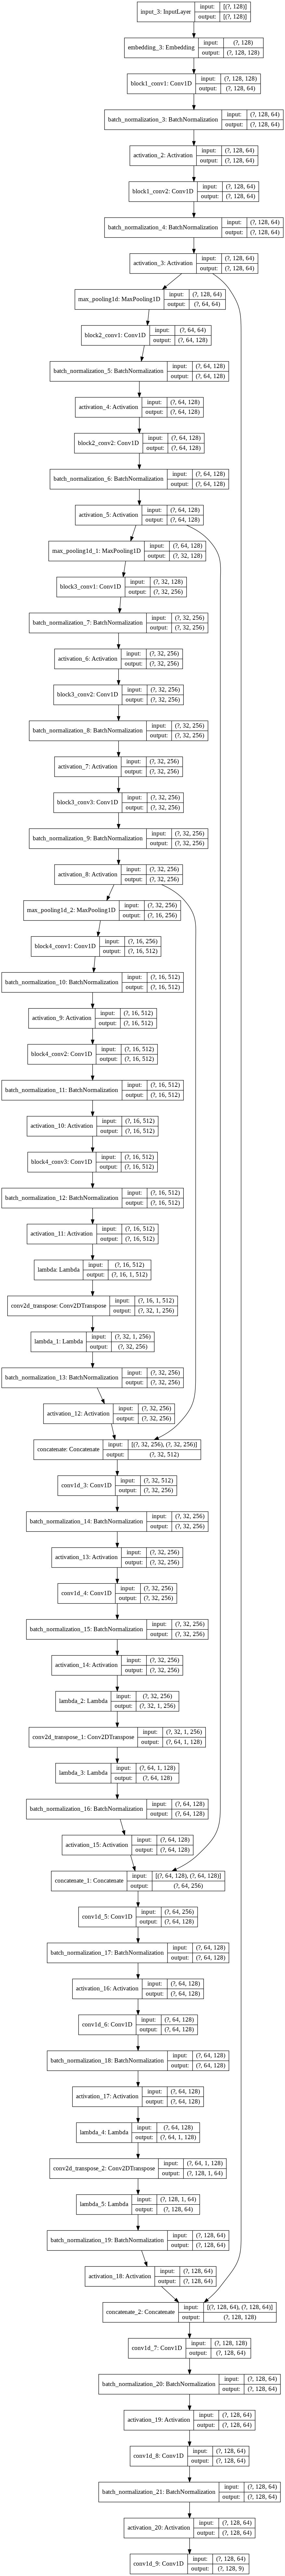

In [91]:
modelUnet = unet(colors_count, sent_len, num_words, 'softmax', emb_size) # Создаем модель unet
plot_model(modelUnet, show_shapes=True)


In [92]:
historyUnet = modelUnet.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=16,
                    validation_data=(Xtest, Ytest),  
                    callbacks=callbacks_list,
                    verbose=1) 
                    
modelUnet.save( '/content/drive/My Drive/tmp/modelUnet_100epochs(gl_extr).h5' )

Epoch 1/100
114/114 [==============================] - ETA: 0s - loss: 0.3665 - dice_coef: 0.8188
Epoch 00001: val_dice_coef did not improve from 0.95379
114/114 [==============================] - 4s 33ms/step - loss: 0.3665 - dice_coef: 0.8188 - val_loss: 0.5237 - val_dice_coef: 0.8695
Epoch 2/100
114/114 [==============================] - ETA: 0s - loss: 0.1490 - dice_coef: 0.9256
Epoch 00002: val_dice_coef did not improve from 0.95379
114/114 [==============================] - 3s 25ms/step - loss: 0.1490 - dice_coef: 0.9256 - val_loss: 0.6791 - val_dice_coef: 0.9012
Epoch 3/100
114/114 [==============================] - ETA: 0s - loss: 0.0797 - dice_coef: 0.9586
Epoch 00003: val_dice_coef did not improve from 0.95379
114/114 [==============================] - 3s 25ms/step - loss: 0.0797 - dice_coef: 0.9586 - val_loss: 0.6545 - val_dice_coef: 0.9036
Epoch 4/100
113/114 [============================>.] - ETA: 0s - loss: 0.0485 - dice_coef: 0.9726
Epoch 00004: val_dice_coef did not imp

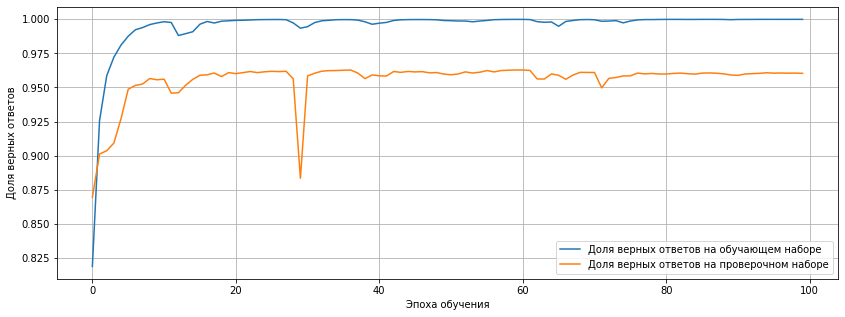

In [93]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyUnet.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyUnet.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [94]:
YpredUnet = modelUnet.predict(Xtest)

In [95]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredUnet.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.99      0.98      0.99     52328
      расшифровка       0.72      0.77      0.75      1811
      определение       0.70      0.83      0.76      1849
           термин       0.78      0.77      0.77       746
           связка       0.81      0.86      0.83       566
     дубль-термин       0.62      0.39      0.48       249
дубль-определение       0.31      0.22      0.25       172
     дубль-связка       0.34      0.29      0.31        79
дубль-расшифровка       0.00      0.00      0.00        56

         accuracy                           0.96     57856
        macro avg       0.59      0.57      0.57     57856
     weighted avg       0.96      0.96      0.96     57856



**Проверка тестовой выборки (насколько хорошо обучена сеть)**

In [ ]:
# выбираем конкретную фразу из тестовой выборки
i = 2
print(f'{i + 1}.')
print(tokens_to_text(Xtest[i], Ytest[i]))
print(tokens_to_text(Xtest[i], YpredUnet[i]))

In [97]:
# воспроизводим все фразы из тестовой выборки
for i, el in enumerate(Xtest):
  print(f'{i+1}.')
  print(tokens_to_text(el, Ytest[i]))
  print(tokens_to_text(el, YpredUnet[i]))

# На github не отображается расцветка текста
# Чтобы её посмотреть, воспользуйтесь ссылкой на https://colab.research.google.com/ выше

1.
 удобный поиск — возможность использования эффективной системы поиска ( полнотекстовый поиск , одновременный поиск в нескольких словарях , высокая скорость поиска ) [ 26 ] .
 удобный поиск — возможность использования эффективной системы поиска ( полнотекстовый поиск , одновременный поиск в нескольких словарях , высокая скорость поиска ) [ 26 ] .
2.
 синтаксический анализатор ( жарг. парсер ← англ. parser ) — это программа или часть программы , выполняющая синтаксический анализ .
 синтаксический анализатор ( жарг. парсер ← англ. parser ) — это программа или часть программы , выполняющая синтаксический анализ .
3.
 свойство — необходимое условие принадлежности классу .
 свойство — необходимое условие принадлежности классу .
4.
 парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее пон

### **Simplified U-net**

In [98]:
def simpleUnet(
      num_classes = 9,
      sentence_len = 200,
      num_words = 5000,
      activation_function = 'softmax',
      embedding_size = 50
      ):
    print('num_classes=',num_classes)
    print('sentence_len=',sentence_len)
    print('num_words=',num_words)
    print('embedding_size=',embedding_size)

    txt_input = Input((sentence_len,))                                         # Создаем входной слой с размерностью input_shape
    print('txt_input=',txt_input.shape)
    emb = Embedding(num_words, embedding_size)(txt_input)
    print('emb=',emb.shape)

    # Block 1
    x = Conv1D(32, 3, padding='same', name='block1_conv1')(emb) # Добавляем Conv1D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(32, 3, padding='same', name='block1_conv2')(x)         # Добавляем Conv1D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling1D()(block_1_out)                                        # Добавляем слой MaxPooling1D

    # Block 2
    x = Conv1D(64, 3, padding='same', name='block2_conv1')(x)         # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same', name='block2_conv2')(x)         # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling1D()(block_2_out)                                        # Добавляем слой MaxPooling1D
    
    # UP 1
    # x = Conv1DTranspose(x, 64, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 64 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(64, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same')(x)                              # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same')(x)                              # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 2
    # x = Conv1DTranspose(x, 32, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 32 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(32, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(32, 3, padding='same')(x)                              # Добавляем Conv1D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(32, 3, padding='same')(x)                              # Добавляем Conv1D-слой с 32-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(num_classes,3, activation=activation_function, padding='same')(x) # Добавляем Conv1D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(txt_input, x)                                            # Создаем модель с входом 'txt_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model                                                           # Возвращаем модель

num_classes= 9
sentence_len= 128
num_words= 11600
embedding_size= 128
txt_input= (None, 128)
emb= (None, 128, 128)


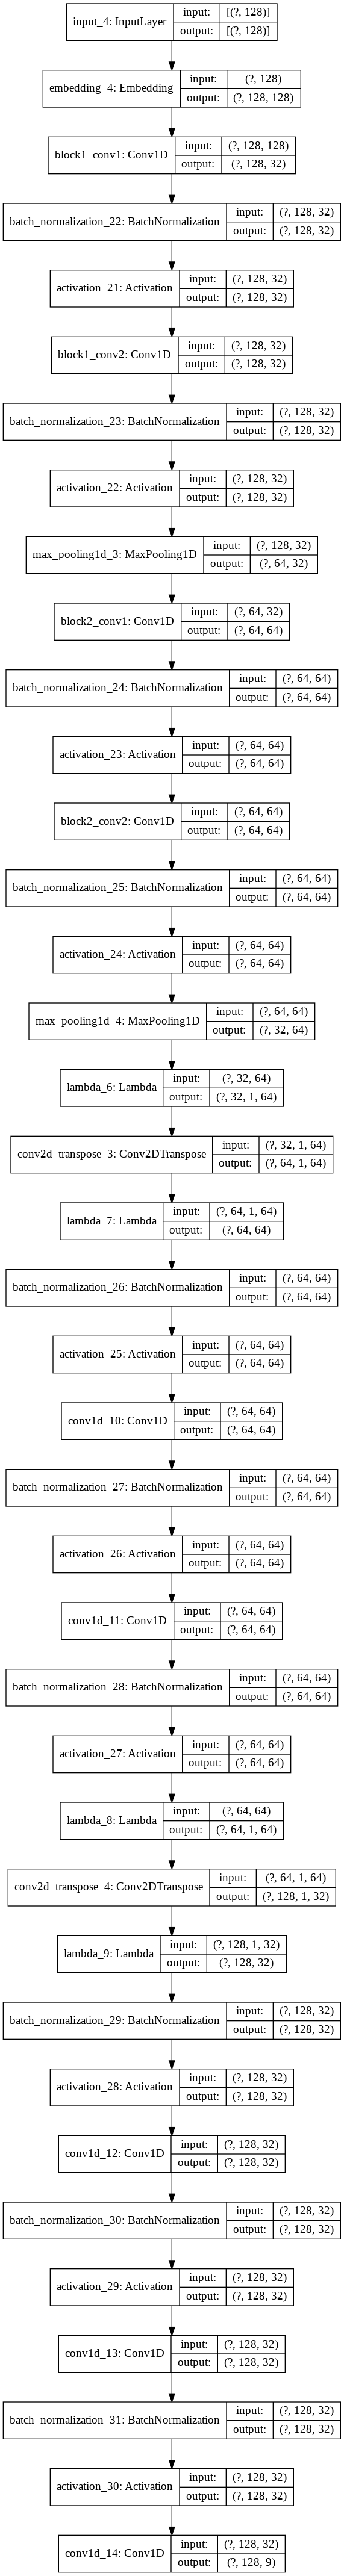

In [99]:
modelS = simpleUnet(colors_count, sent_len, num_words, 'softmax', emb_size) # Создаем модель simpleUnet
plot_model(modelS, show_shapes=True)

In [100]:
historyS = modelS.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=16,
                    validation_data=(Xtest, Ytest)) # Обучаем модель на выборке по трем классам

Epoch 1/100
114/114 [==============================] - 2s 21ms/step - loss: 0.4671 - dice_coef: 0.7558 - val_loss: 0.5382 - val_dice_coef: 0.7480
Epoch 2/100
114/114 [==============================] - 2s 17ms/step - loss: 0.2149 - dice_coef: 0.8930 - val_loss: 0.5938 - val_dice_coef: 0.8906
Epoch 3/100
114/114 [==============================] - 2s 17ms/step - loss: 0.1518 - dice_coef: 0.9256 - val_loss: 0.6173 - val_dice_coef: 0.8992
Epoch 4/100
114/114 [==============================] - 2s 17ms/step - loss: 0.1165 - dice_coef: 0.9418 - val_loss: 0.4683 - val_dice_coef: 0.9006
Epoch 5/100
114/114 [==============================] - 2s 17ms/step - loss: 0.0959 - dice_coef: 0.9514 - val_loss: 0.3495 - val_dice_coef: 0.9118
Epoch 6/100
114/114 [==============================] - 2s 18ms/step - loss: 0.0797 - dice_coef: 0.9582 - val_loss: 0.2523 - val_dice_coef: 0.9274
Epoch 7/100
114/114 [==============================] - 2s 18ms/step - loss: 0.0728 - dice_coef: 0.9617 - val_loss: 0.2147 - 

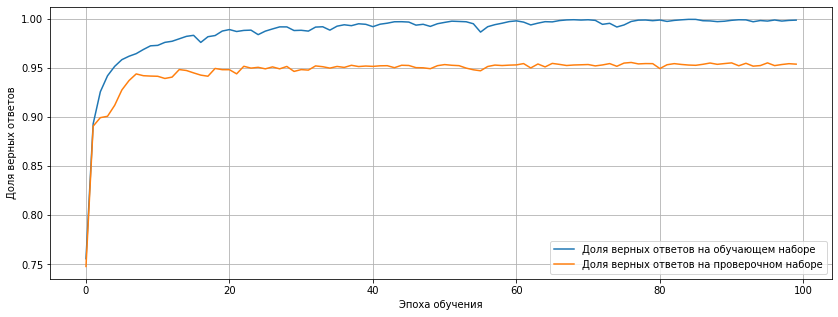

In [101]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyS.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyS.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [102]:
YpredS = modelS.predict(Xtest)

In [103]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredS.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.98      0.98      0.98     52328
      расшифровка       0.66      0.70      0.68      1811
      определение       0.75      0.74      0.75      1849
           термин       0.81      0.73      0.77       746
           связка       0.83      0.75      0.78       566
     дубль-термин       0.44      0.33      0.38       249
дубль-определение       0.16      0.18      0.17       172
     дубль-связка       0.17      0.13      0.15        79
дубль-расшифровка       0.15      0.12      0.14        56

         accuracy                           0.95     57856
        macro avg       0.55      0.52      0.53     57856
     weighted avg       0.95      0.95      0.95     57856



### **Extended U-net**

In [104]:
def unetWithMask(
      num_classes = 9,
      sentence_len = 200,
      num_words = 5000,
      activation_function = 'softmax',
      embedding_size = 50
      ):
    print('num_classes=',num_classes)
    print('sentence_len=',sentence_len)
    print('num_words=',num_words)
    print('embedding_size=',embedding_size)

    txt_input = Input((sentence_len,))                                         # Создаем входной слой с размерностью input_shape
    print('txt_input=',txt_input.shape)
    emb = Embedding(num_words, embedding_size)(txt_input)
    print('emb=',emb.shape)

    # Block 1
    x = Conv1D(64, 3, padding='same', name='block1_conv1')(emb) # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same', name='block1_conv2')(x)      # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_1_out
    
    block_1_out_mask = Conv1D(64, 1, padding='same')(block_1_out)  # Добавляем Conv1D-маску к текущему слою и запоминаем в переменную block_1_out_mask

    x = MaxPooling1D()(block_1_out) # Добавляем слой MaxPooling1D

    # Block 2
    x = Conv1D(128, 3, padding='same', name='block2_conv1')(x)     # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv1D(128, 3, padding='same', name='block2_conv2')(x)     # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_2_out

    block_2_out_mask = Conv1D(128, 1, padding='same')(block_2_out) # Добавляем Conv1D-маску к текущему слою и запоминаем в переменную block_2_out_mask
    
    x = MaxPooling1D()(block_2_out)                                     # Добавляем слой MaxPooling1D

    # Block 3
    x = Conv1D(256, 3, padding='same', name='block3_conv1')(x)     # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same', name='block3_conv2')(x)     # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same', name='block3_conv3')(x)     # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_3_out

    block_3_out_mask = Conv1D(256, 1, padding='same')(block_3_out) # Добавляем Conv1D-маску к текущему слою и запоминаем в переменную block_3_out_mask
        
    x = MaxPooling1D()(block_3_out)                                     # Добавляем слой MaxPooling1D

     # Block 4
    x = Conv1D(512, 3, padding='same', name='block4_conv1')(x)     # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block4_conv2')(x)     # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block4_conv3')(x)     # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_4_out

    block_4_out_mask = Conv1D(512, 1, padding='same')(block_4_out) # Добавляем Conv1D-маску к текущему слою и запоминаем в переменную block_4_out_mask
            
    x = MaxPooling1D()(block_4_out)                                     # Добавляем слой MaxPooling1D

    # Block 5
    x = Conv1D(512, 3, padding='same', name='block5_conv1')(x)     # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block5_conv2')(x)     # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block5_conv3')(x)     # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation
    
    for_pretrained_weight = MaxPooling1D()(x)                           # Добавляем слой MaxPooling1D
 
    # UP 1
    # x = Conv1DTranspose(x, 512, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 512 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(512, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_4_out, block_4_out_mask])                 # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv1D(512, 3, padding='same')(x)                          # Добавляем слой Conv1D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same')(x)                          # Добавляем слой Conv1D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 2
    # x = Conv1DTranspose(x, 256, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 256 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(256, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_3_out, block_3_out_mask])                 # Объединем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
    x = Conv1D(256, 3, padding='same')(x)                          # Добавляем слой Conv1D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same')(x)                          # Добавляем слой Conv1D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 3
    # x = Conv1DTranspose(x, 128, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 128 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(128, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_2_out_mask])                 # Объединем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
    x = Conv1D(128, 3, padding='same')(x)                          # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv1D(128, 3, padding='same')(x)                          # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 4
    # x = Conv1DTranspose(x, 64, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 64 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(64, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_1_out_mask])                # Объединем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
    x = Conv1D(64, 3, padding='same')(x)                          # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same')(x)                          # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv1D(num_classes, 3, activation=activation_function, padding='same')(x) # Добавляем Conv1D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(txt_input, x)                                        # Создаем модель с входом 'txt_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model                                                       # Возвращаем сформированную модель

num_classes= 9
sentence_len= 128
num_words= 11600
embedding_size= 128
txt_input= (None, 128)
emb= (None, 128, 128)


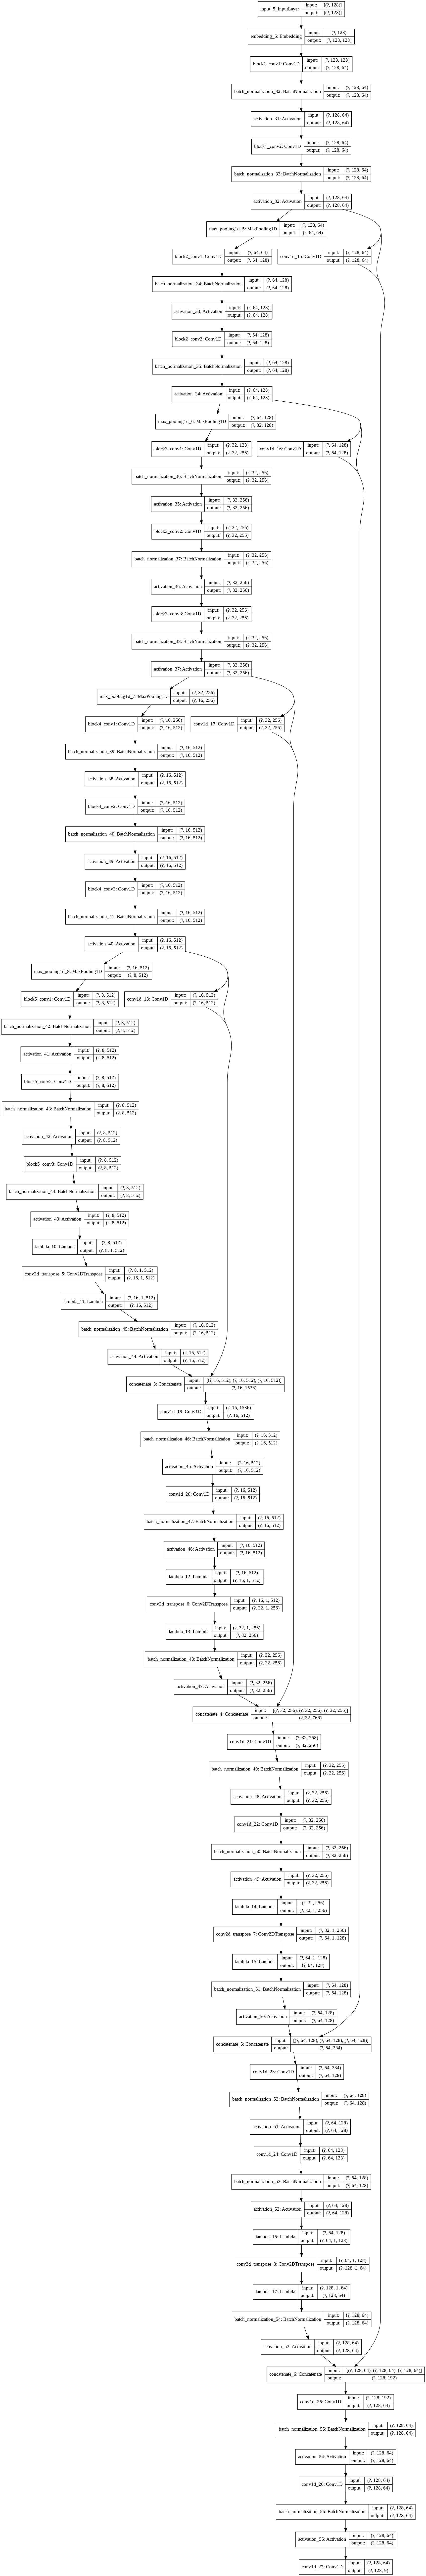

In [105]:
modelM3 = unetWithMask(colors_count, sent_len, num_words, 'sigmoid', emb_size) # Создаем модель unetWithMask
plot_model(modelM3, show_shapes=True)

In [106]:
historyM3 = modelM3.fit(Xtrain, 
                    Ytrain, 
                    epochs=100,
                    batch_size=64,
                    validation_data=(Xtest, Ytest)) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях

Epoch 1/100
29/29 [==============================] - 2s 86ms/step - loss: 1.4922 - dice_coef: 0.3655 - val_loss: 1.6231 - val_dice_coef: 0.3054
Epoch 2/100
29/29 [==============================] - 1s 45ms/step - loss: 0.4725 - dice_coef: 0.7100 - val_loss: 0.7330 - val_dice_coef: 0.6321
Epoch 3/100
29/29 [==============================] - 1s 45ms/step - loss: 0.2228 - dice_coef: 0.8588 - val_loss: 0.5185 - val_dice_coef: 0.7746
Epoch 4/100
29/29 [==============================] - 1s 45ms/step - loss: 0.1316 - dice_coef: 0.9051 - val_loss: 0.4963 - val_dice_coef: 0.8243
Epoch 5/100
29/29 [==============================] - 1s 45ms/step - loss: 0.0828 - dice_coef: 0.9237 - val_loss: 0.5173 - val_dice_coef: 0.8512
Epoch 6/100
29/29 [==============================] - 1s 45ms/step - loss: 0.0536 - dice_coef: 0.9343 - val_loss: 0.5592 - val_dice_coef: 0.8619
Epoch 7/100
29/29 [==============================] - 1s 45ms/step - loss: 0.0367 - dice_coef: 0.9377 - val_loss: 0.6007 - val_dice_coef:

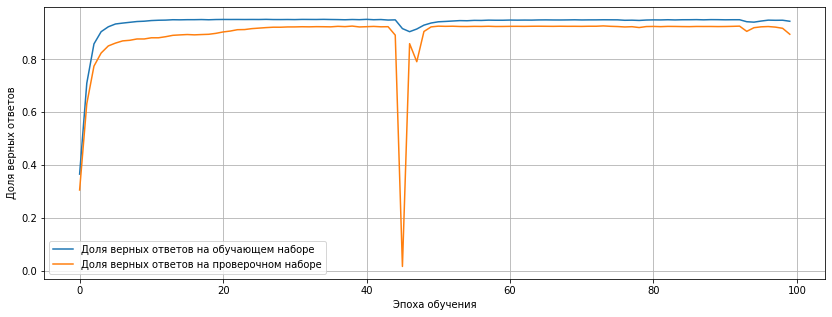

In [107]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyM3.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyM3.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [108]:
YpredM3 = modelM3.predict(Xtest)

In [109]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest.argmax(axis=-1).flatten(), YpredM3.argmax(axis=-1).flatten(), target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.99      0.99      0.99     52328
      расшифровка       0.78      0.59      0.67      1811
      определение       0.63      0.86      0.73      1849
           термин       0.73      0.75      0.74       746
           связка       0.79      0.86      0.82       566
     дубль-термин       0.56      0.33      0.42       249
дубль-определение       0.29      0.13      0.18       172
     дубль-связка       0.19      0.25      0.22        79
дубль-расшифровка       0.00      0.00      0.00        56

         accuracy                           0.96     57856
        macro avg       0.55      0.53      0.53     57856
     weighted avg       0.96      0.96      0.96     57856

